In [ ]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt


from AnalyseCID import AnalyseCID
from utils import *
from utils_plot import *

notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
sys.path.append('data\\config')
sys.path.append('ComputableInformationDensity_dev')


from data.config.dicts import DATA_CONFIGS, FIG_FOLDER_CONFIGS

from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean, calc_acf_for_arr

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
#plt.rcParams['legend.handlelength'] = 0

In [7]:
base_path = f'Z:\\cid\\na'
save_path = f'data\\na'

extract = False
analyze = False
save_figs = True
verbose = True

ordering='z' # 'h' for hilbert, 'z' for z-order
data_suffix = 'abp'  # 'sd', 'ndg', 's', 'f' or ''    
use_seq = False
seq_prefix = '_seq' if use_seq else ''
ordering_suffix = 'zorder' if ordering=='z' else ''

nbits = 8
window_size=64
nframes = 32
cg = 1

if ordering == 'h':
    output_suffix = f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}'
elif ordering == 'z':
    output_suffix = f'_nx{window_size}nt{nframes}cg{cg}'

data_dict = DATA_CONFIGS #[data_suffix]
fig_folder_dict = FIG_FOLDER_CONFIGS

cid_dict = {
    'base_path': base_path,
    'save_path': save_path,
    'output_suffix': output_suffix,
    'nbits': nbits,
    'cg': cg,
    'verbose': verbose,
    'ddof': 1,   
    **data_dict[data_suffix]
}

#output_suffix = data_dict[data_suffix]['output_suffix']
figs_save_path = f'data\\figs\\{fig_folder_dict[data_suffix]}\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): 
    os.makedirs(figs_save_path)


ac = AnalyseCID(cid_dict,)
# Set figure save path
ac.figs_save_path = figs_save_path
if extract:
    #conv_list_dir = save_path + '512'
    ac.run() #conv_list_dir = conv_list_dir)
if analyze and not extract:
    ac.analyze()

In [7]:
n_list=np.logspace(0,4,base=10, num=5).astype(int)
cid_vals = []
for n in n_list:
    x=np.arange(n).astype(int)
    cid_vals.append(cid(x))
cid_vals, np.log2(n_list)

([0.0,
  3.3219280948873626,
  5.6827315074437195,
  7.9728967514644475,
  10.230460288877318],
 array([ 0.        ,  3.32192809,  6.64385619,  9.96578428, 13.28771238]))

In [21]:
cid_var_per_partion.shape

(4, 16)

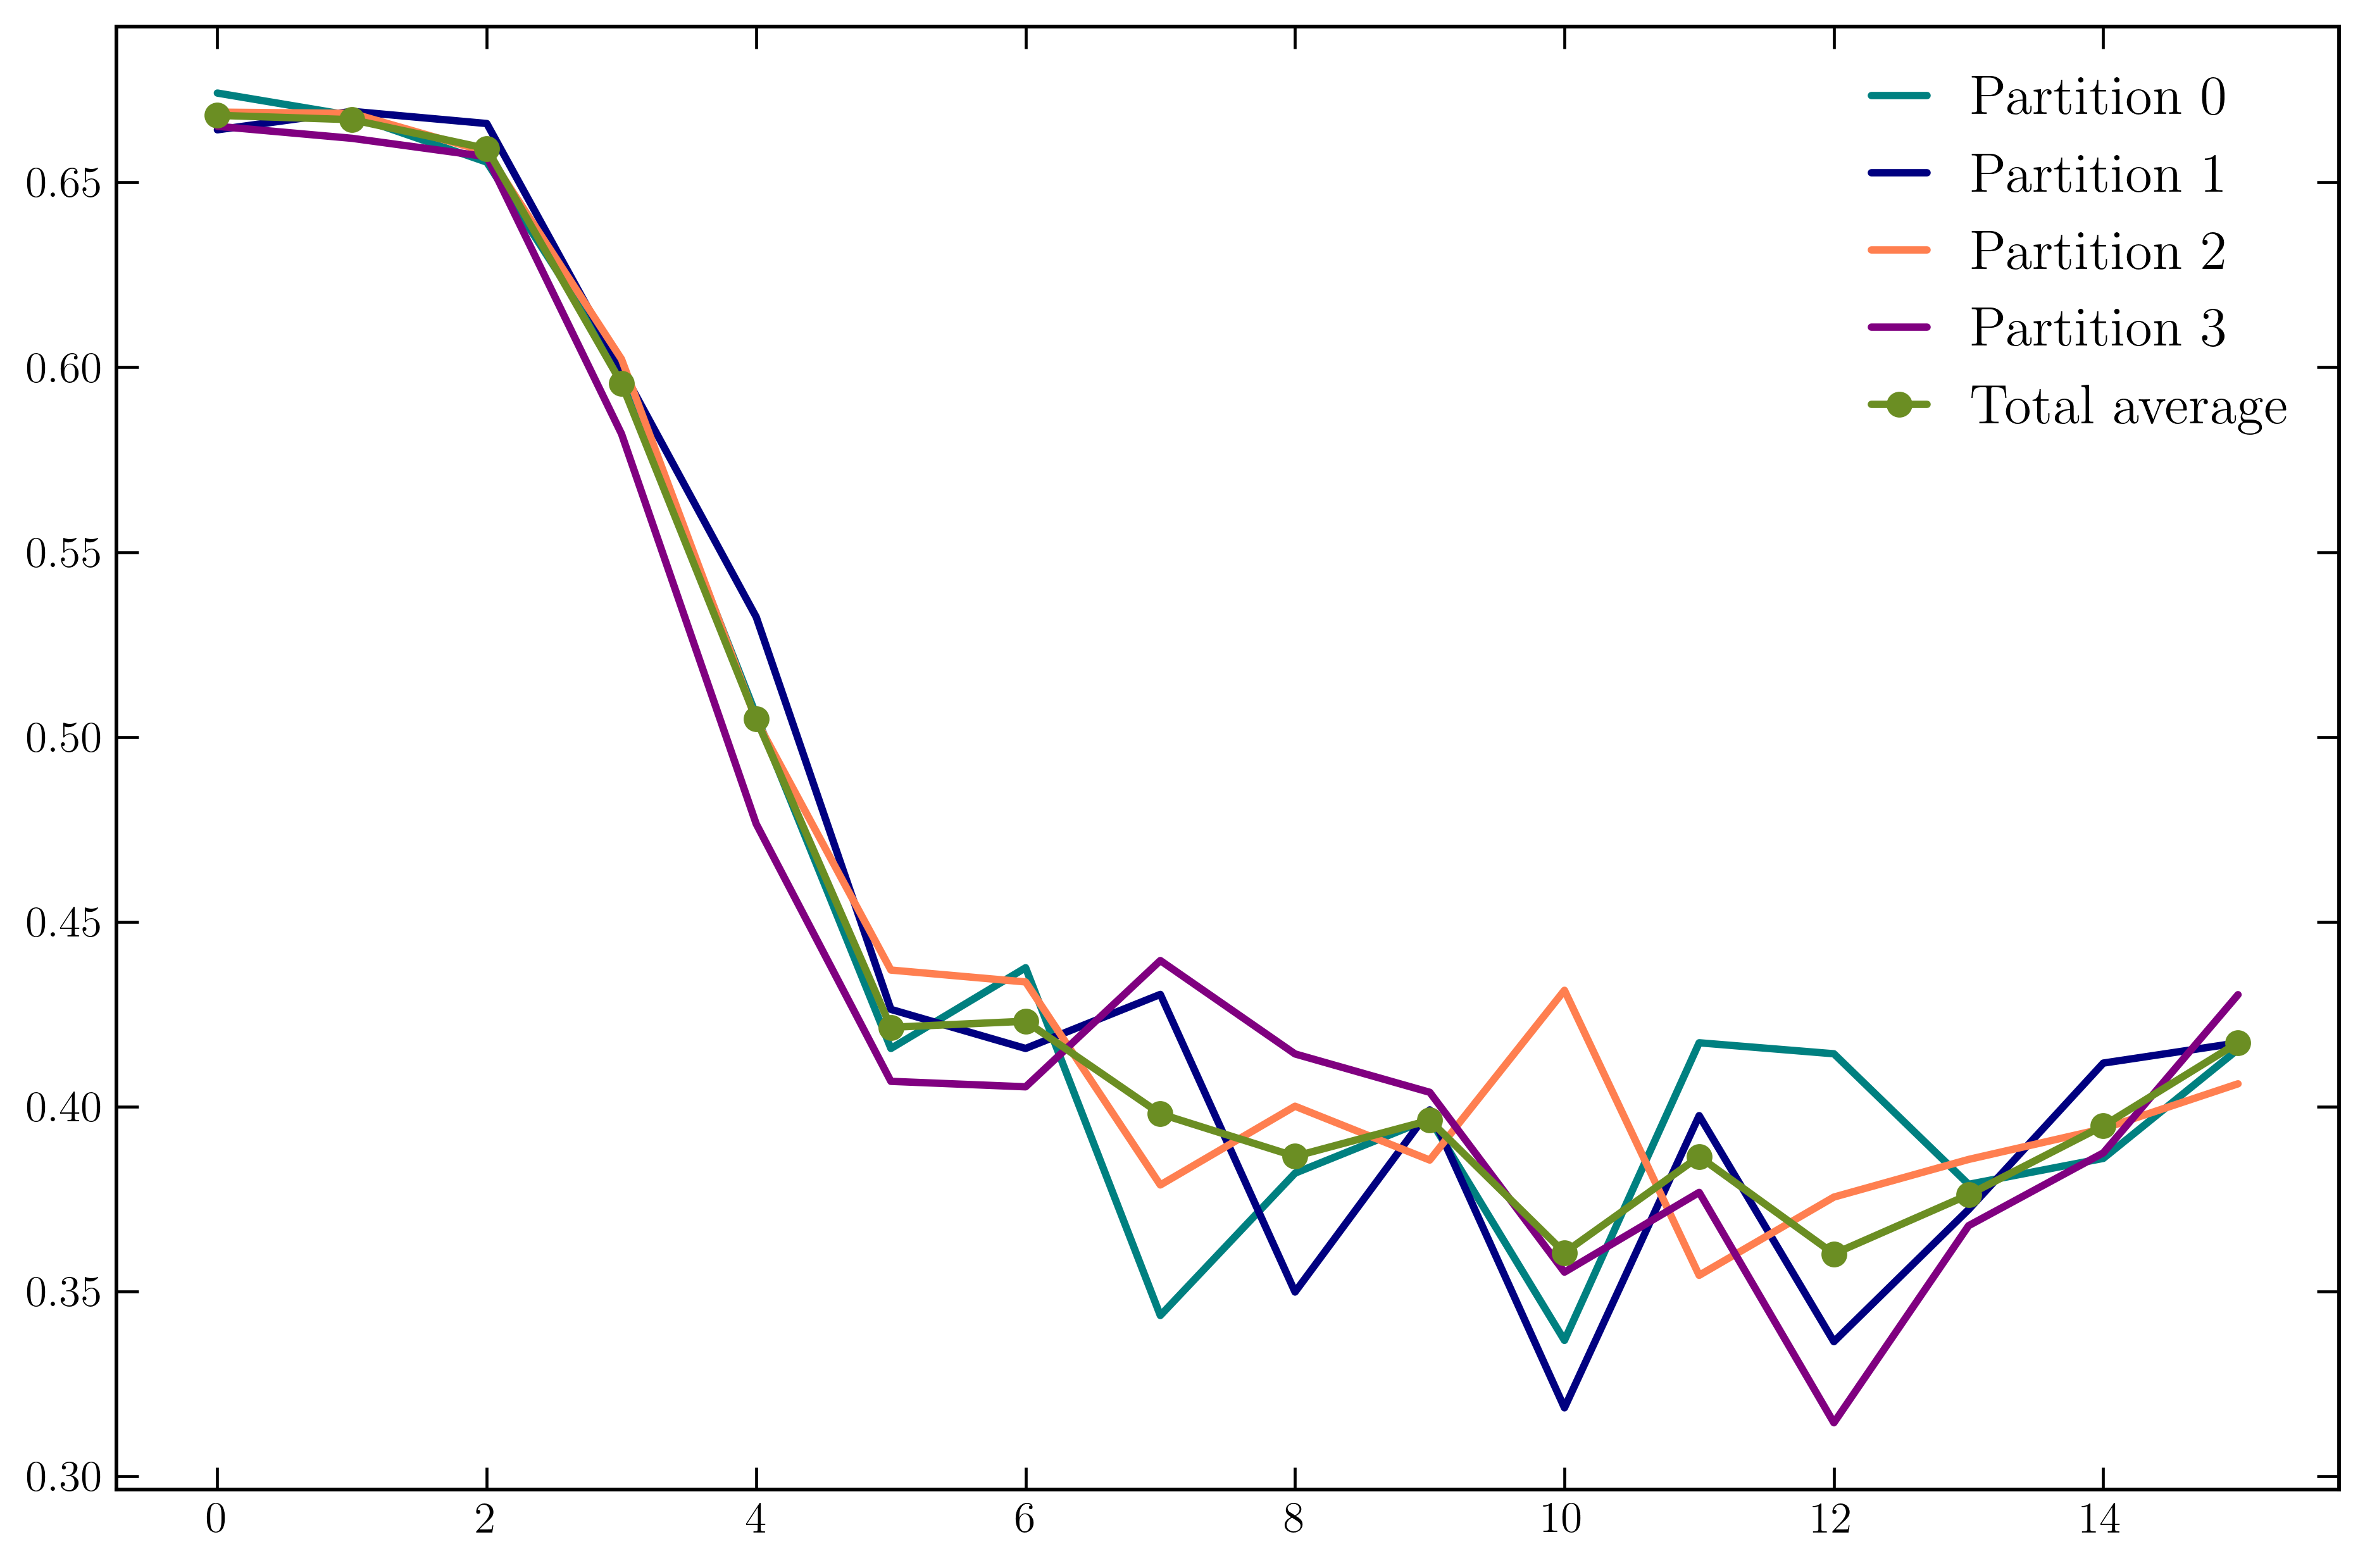

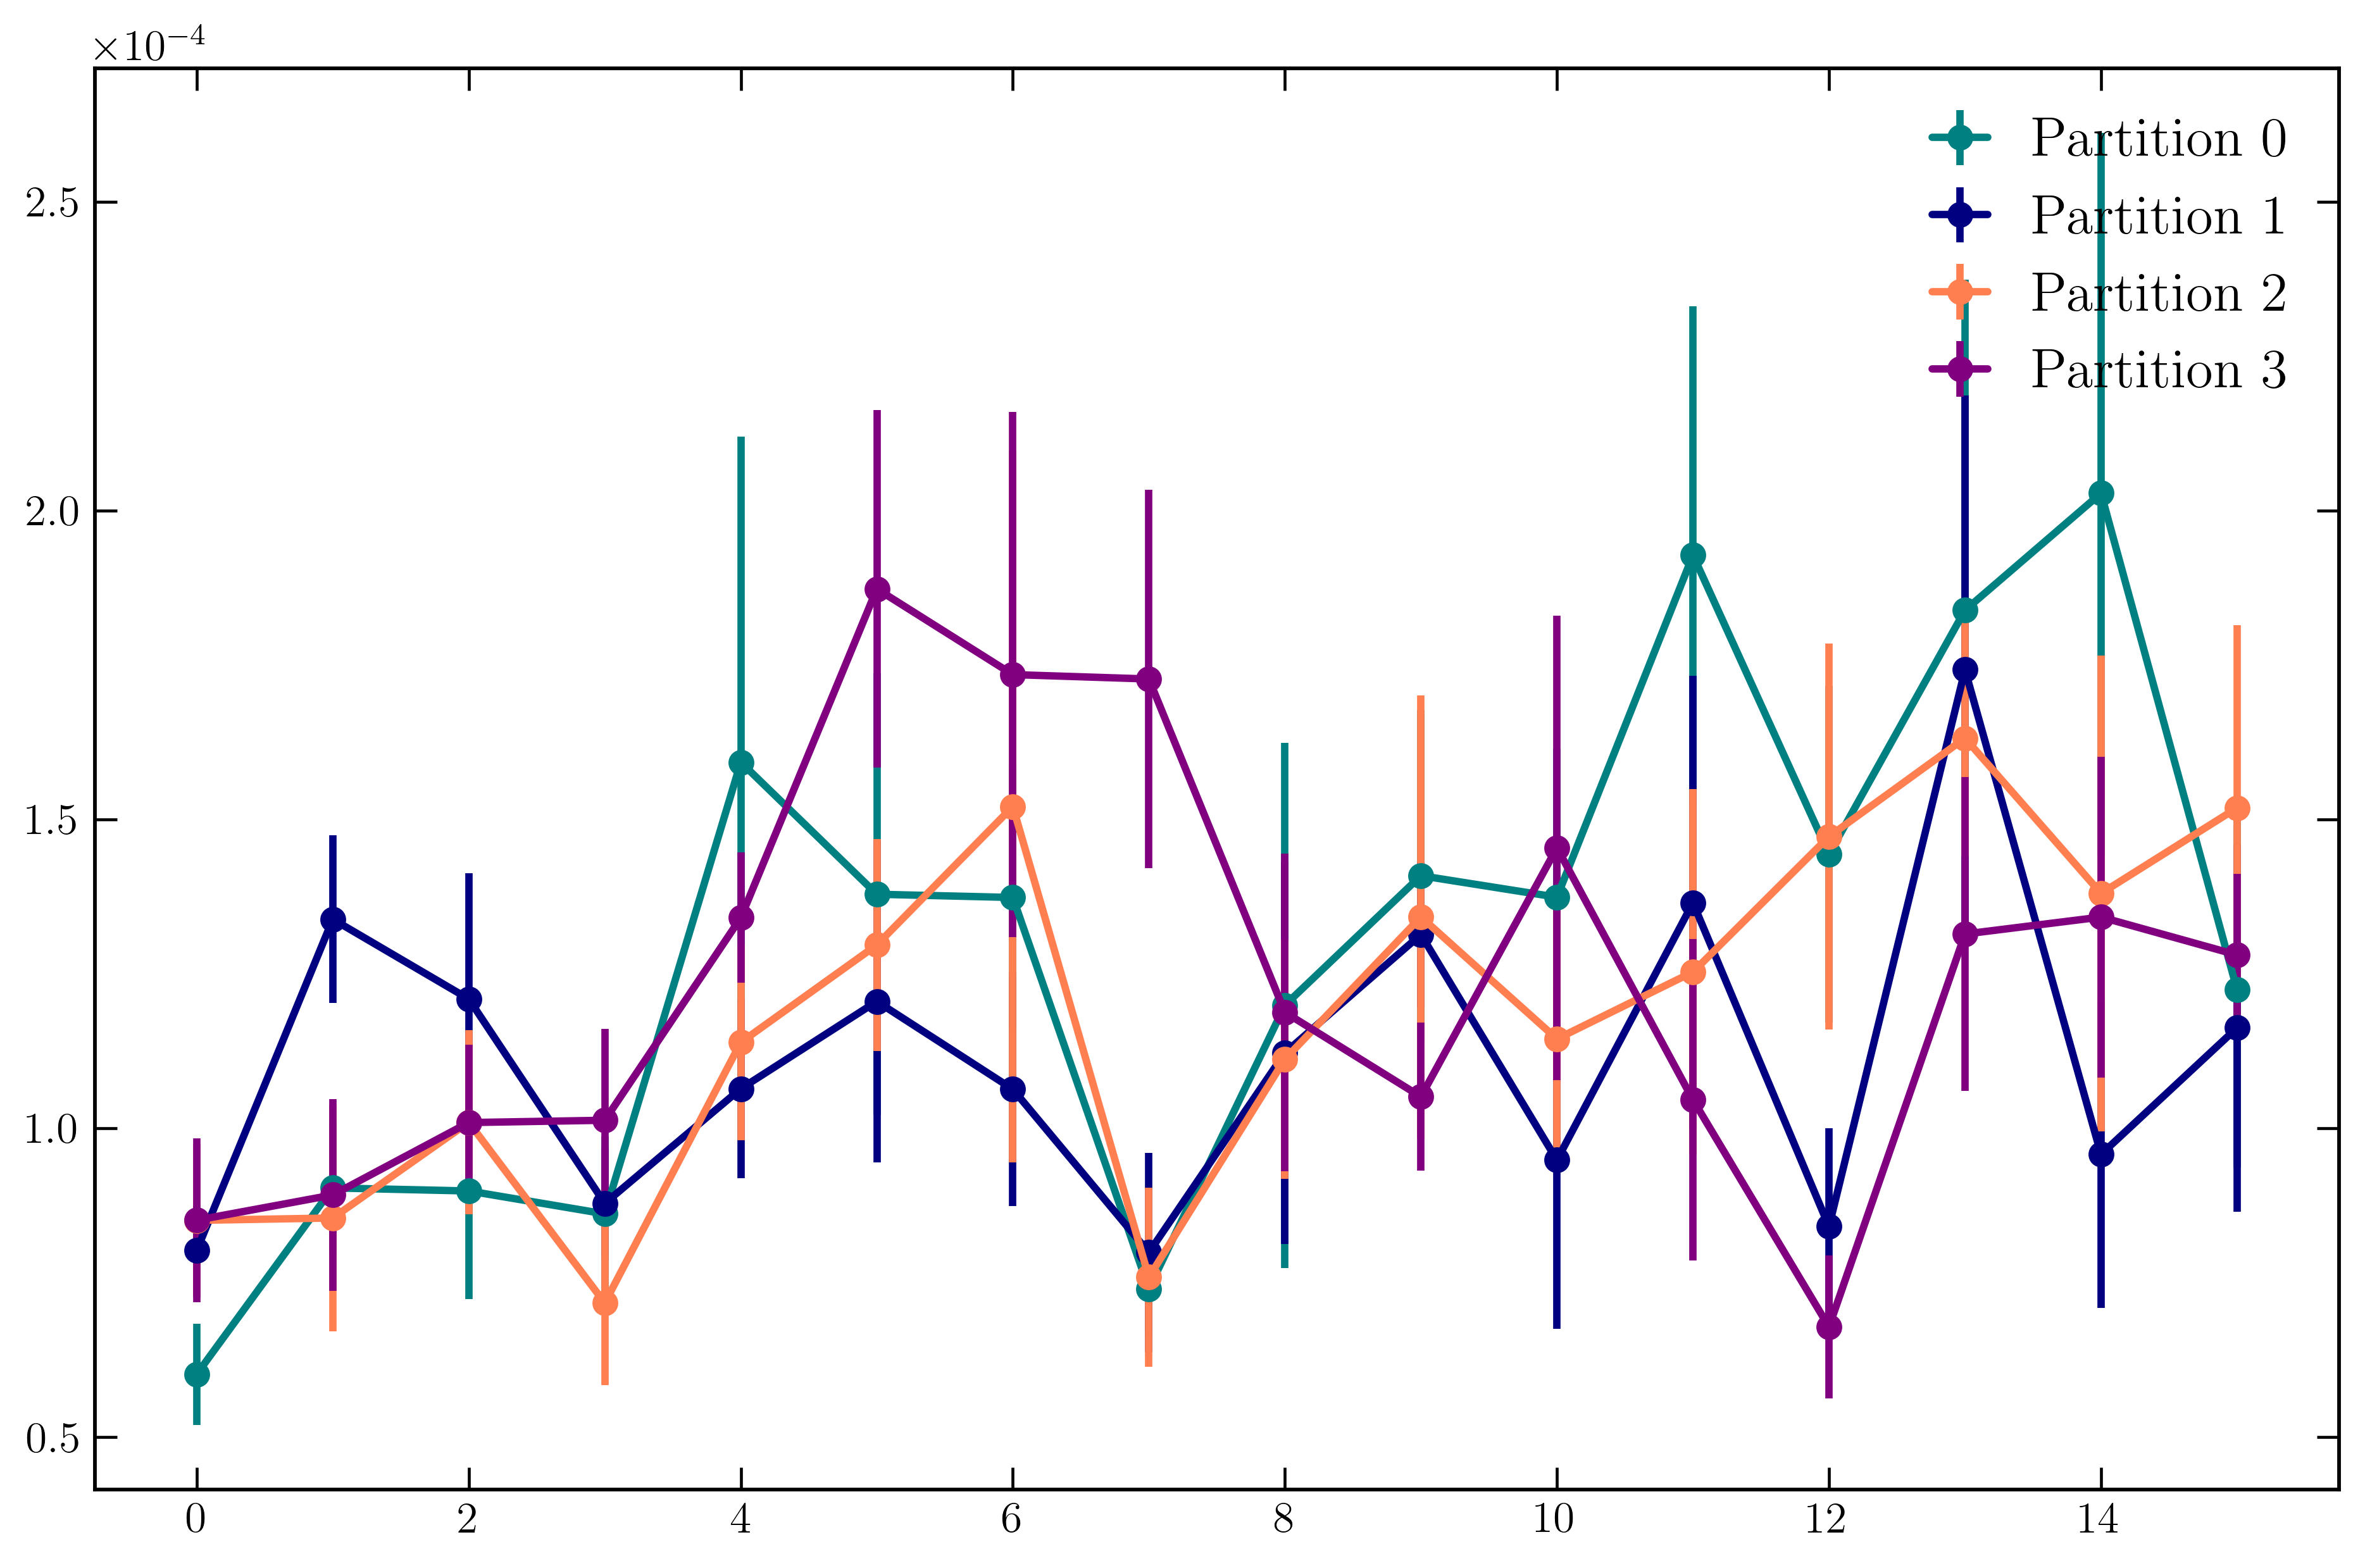

In [24]:
cid_vals = ac.cid[128][...,0]
cid_av_per_partition = np.nanmean(cid_vals[:,:,:,:], axis=(0,-1))
cid_var_per_partition_per_exp = np.nanvar(cid_vals[:,:,:,:], axis=(0,))
cid_var_per_partion = np.nanmean(cid_var_per_partition_per_exp, axis=(-1,))
cid_var_per_partion_sem = np.nanstd(cid_var_per_partition_per_exp, axis=(-1,)) / np.sqrt(cid_vals.shape[0])

for i in range(cid_av_per_partition.shape[0]):
    plt.plot(cid_av_per_partition[i,:], label=f'Partition {i}')
plt.plot(ac.cid_tav[128][:,0], 'o-', label='Total average')
plt.legend(handlelength=1)

plt.figure()
for i in range(cid_var_per_partion.shape[0]):
    plt.errorbar(np.arange(cid_var_per_partion.shape[1]), cid_var_per_partion[i,:], yerr=cid_var_per_partion_sem[i,:], label=f'Partition {i}', fmt='o-')
#plt.plot(ac.cid_var[128][:,0], 's-', label='Total variance')
plt.legend(handlelength=1)

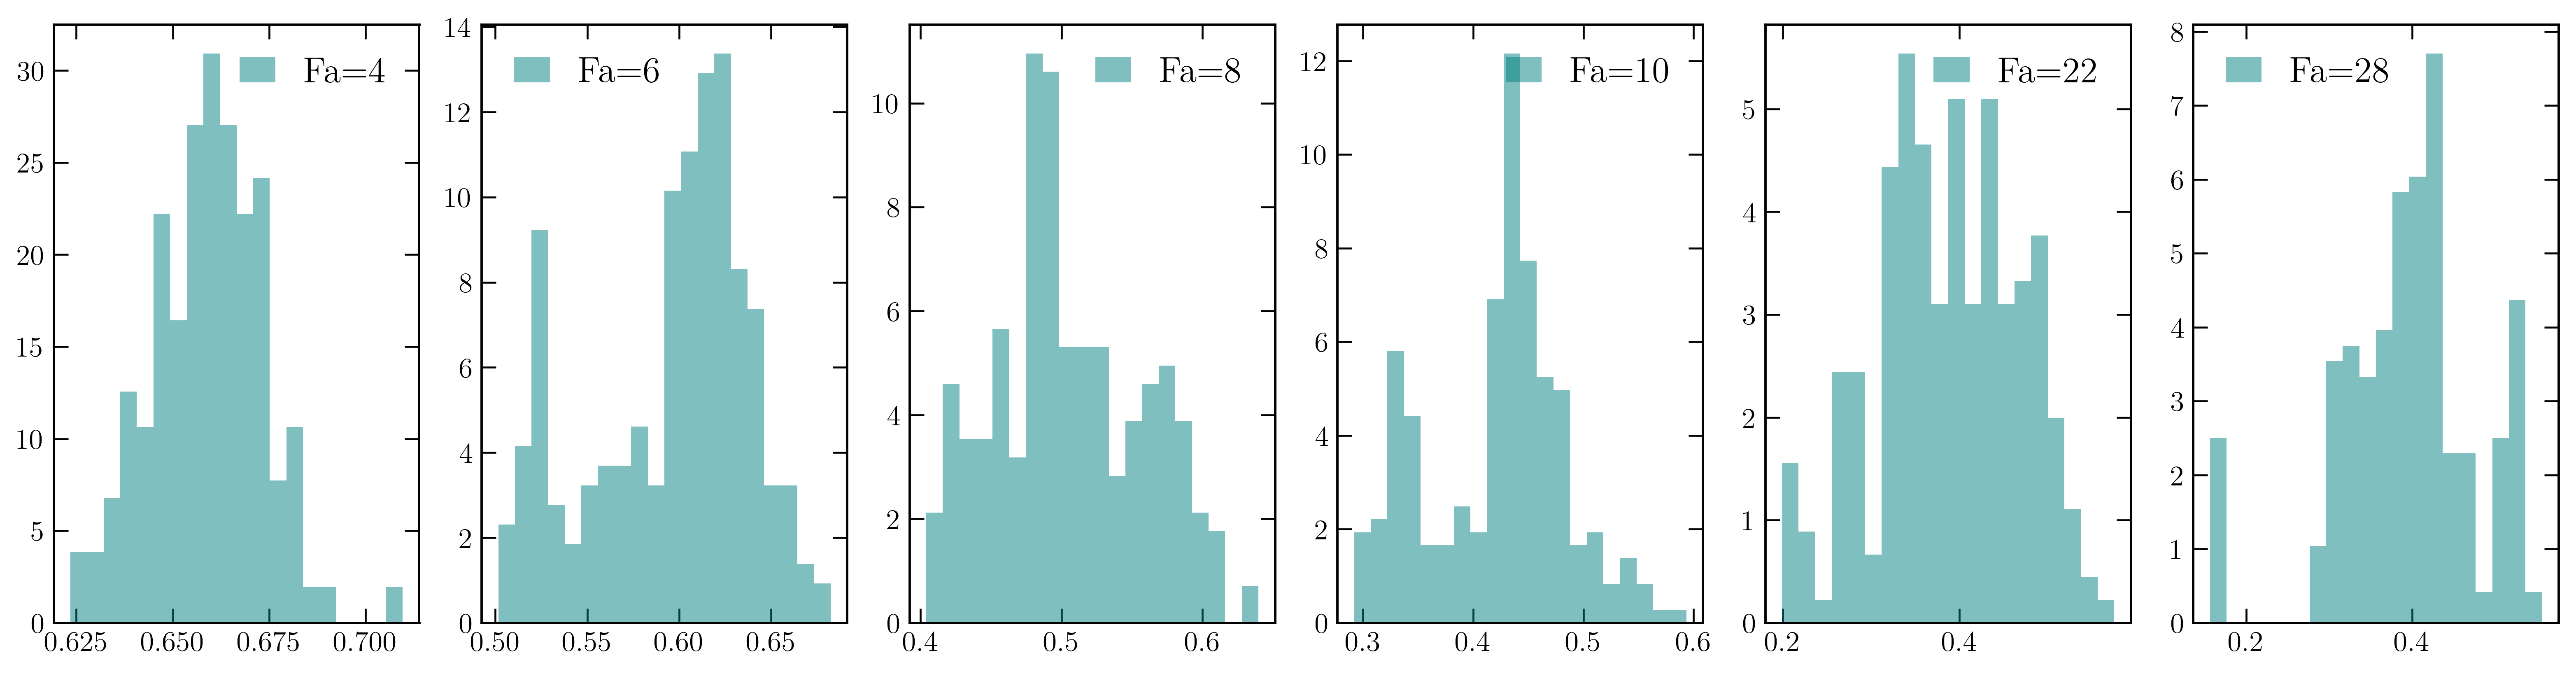

In [8]:
fa_list=[4,6, 8,10,22, 28]
ncols =len(fa_list)
# plot histograms of cid values for different activity values
fig, ax = plt.subplots(ncols=len(fa_list), figsize=(2.5*ncols,4))
for i, fa in enumerate(fa_list):
    fa_idx = np.where(ac.act[128]==fa)[0][0]
    cid_vals_fa = ac.cid[128][...,0][:, :, fa_idx,:].flatten()
    ax[i].hist(cid_vals_fa, bins=20, density=True, alpha=0.5, label=f'Fa={fa}')
    ax[i].legend(handlelength=1)

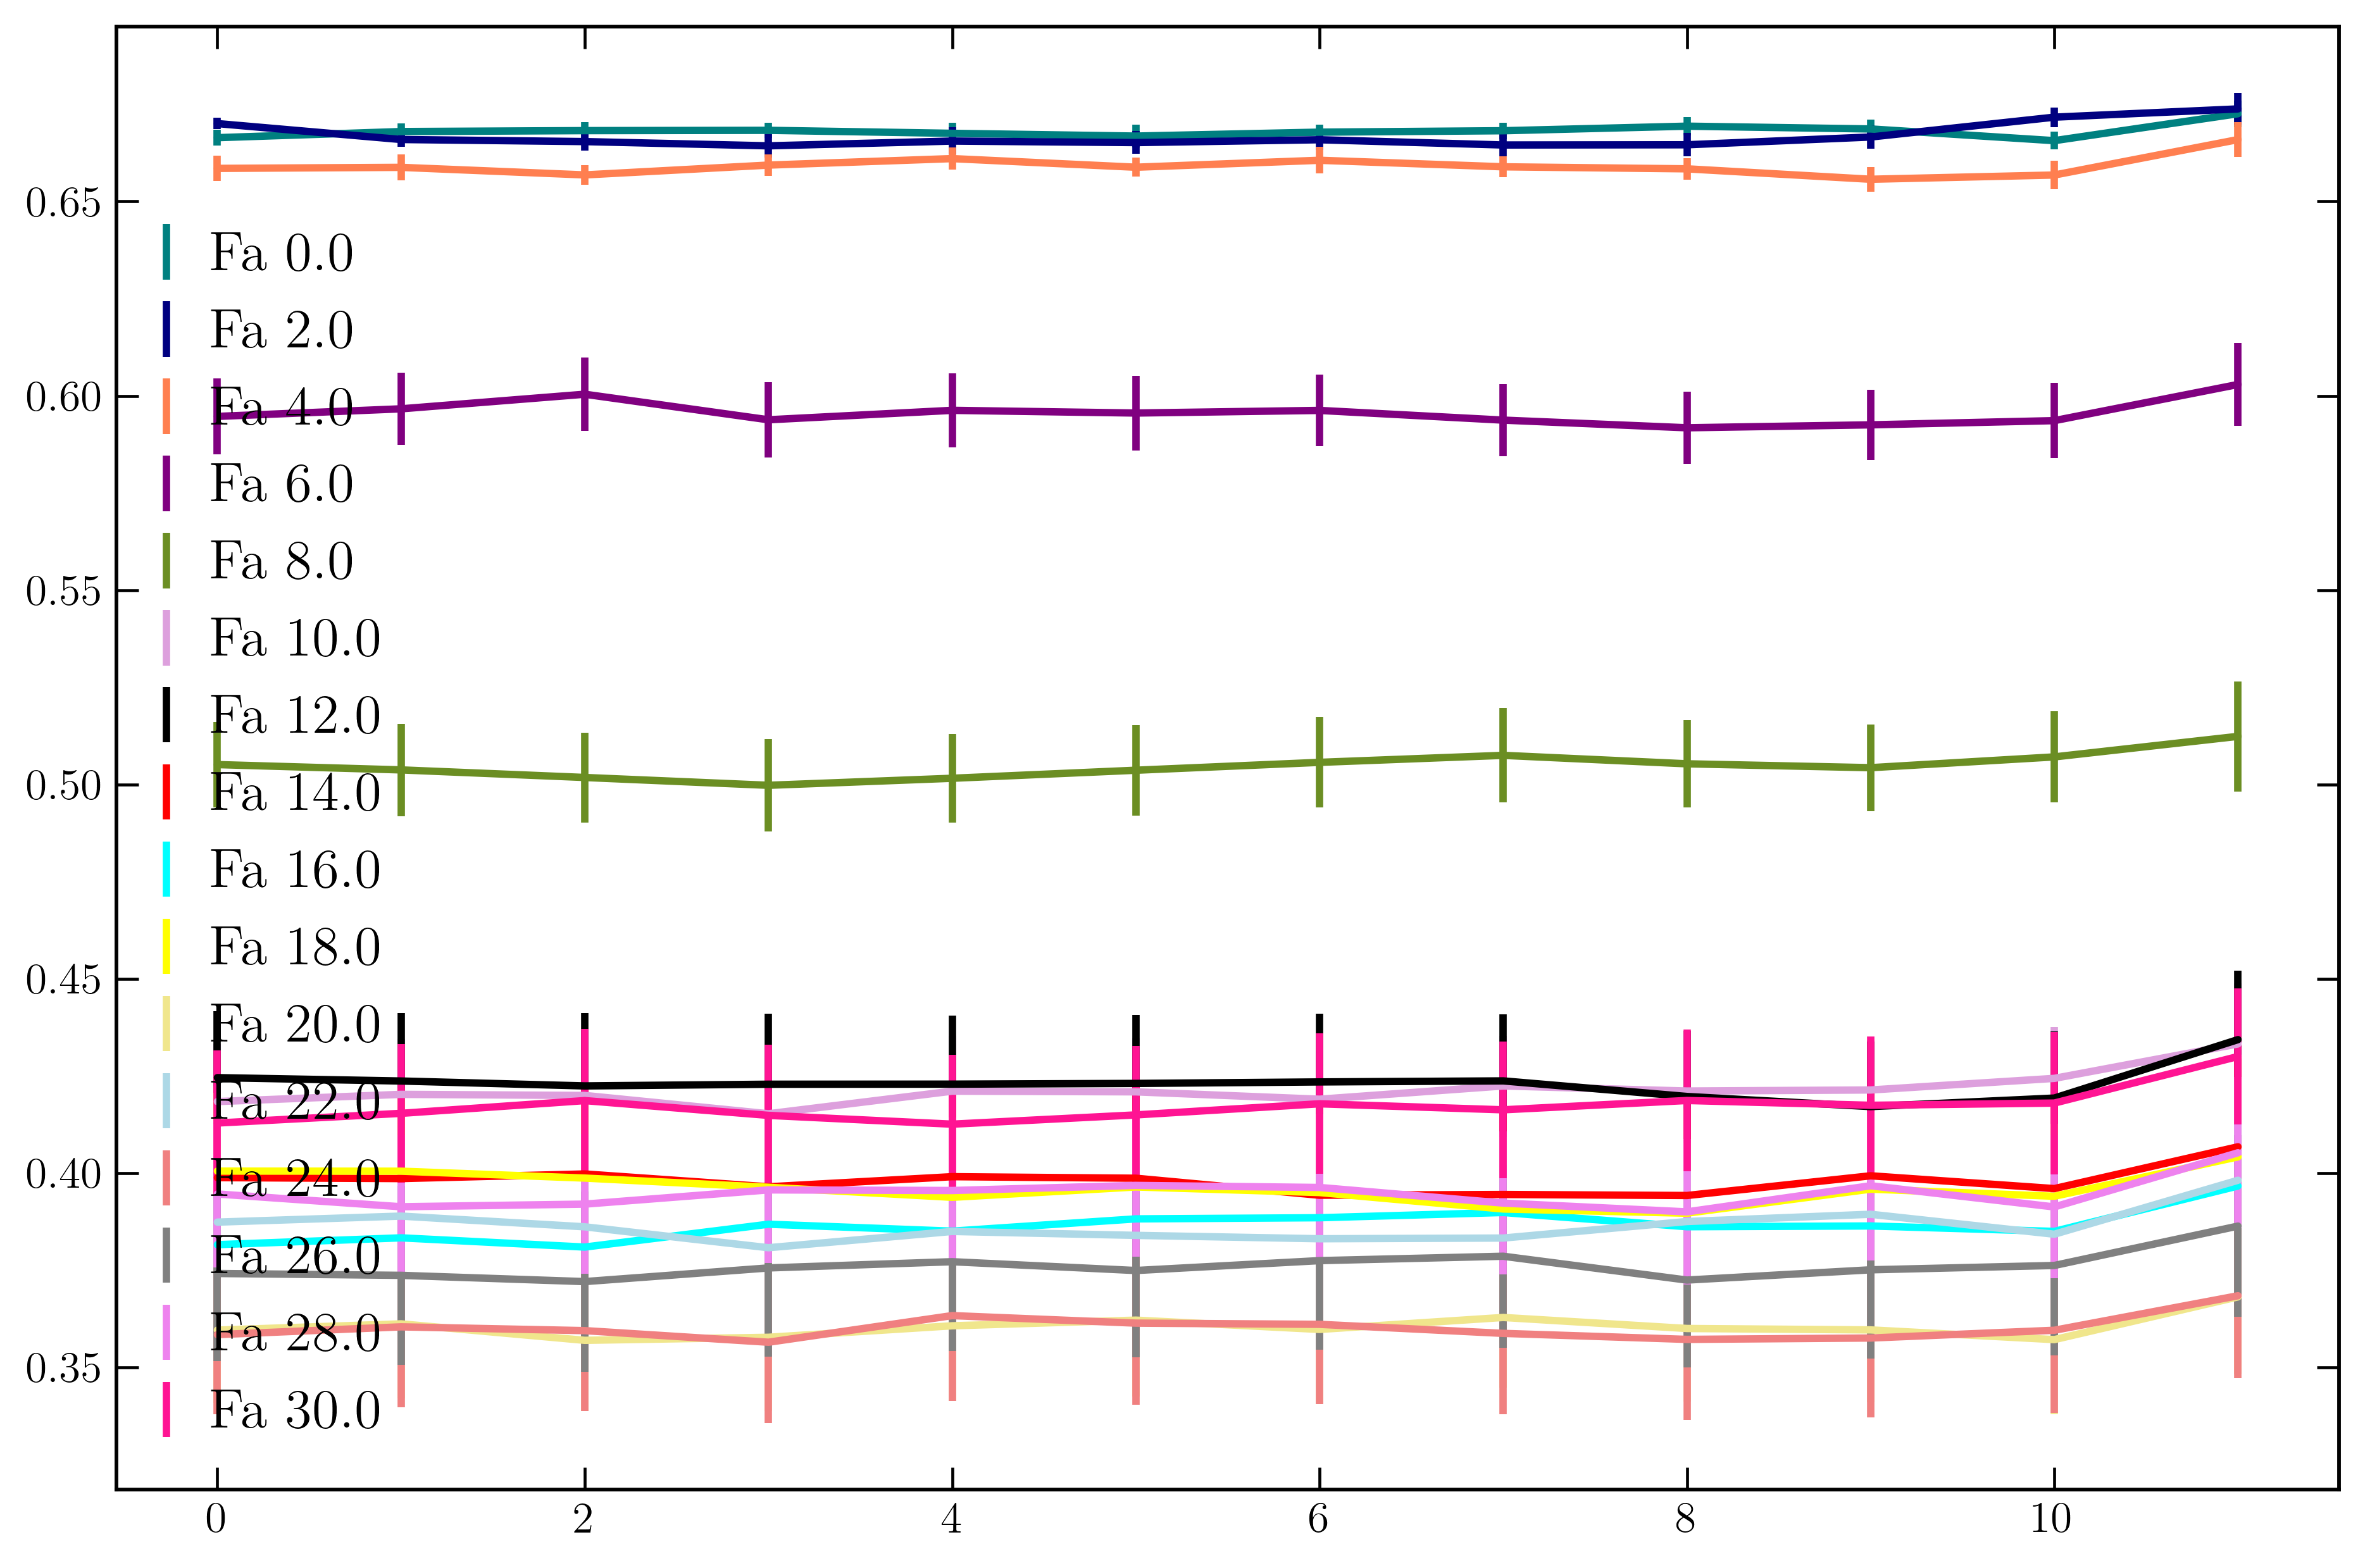

In [26]:
cid_vals=ac.cid[128][...,0]
cid_vals_act_av = ac.cid[128][...,0].mean(axis=(1,-1))
cid_vals_std = ac.cid[128][...,0].std(axis=(1,-1)) / np.sqrt(ac.cid[128][...,0].shape[1]*ac.cid[128][...,0].shape[-1])

for i, act in enumerate(ac.act[128]):
   #¤
   #  print(f"ACT: {act:.5f}, CID mean: {cid_vals_act_av[i]:.5f}, CID std: {cid_vals_std[i]:.5f}")
    plt.errorbar(np.arange(cid_vals_act_av.shape[0]), cid_vals_act_av[:,i], yerr=cid_vals_std[:,i], label=f'Fa {act}')
plt.legend()


In [25]:
ac.cid[128][...,0].shape

(12, 4, 16, 5)

In [ ]:
calc_acf_for_arr(ac.cid[128][...,0][:,0,])

{512: array([0.0195, 0.0205, 0.021 , 0.0215, 0.022 , 0.023 , 0.024 , 0.0245,
        0.025 , 0.0255, 0.026 , 0.027 , 0.028 , 0.029 , 0.03  , 0.032 ,
        0.034 , 0.04  , 0.05  , 0.06  , 0.07  ])}

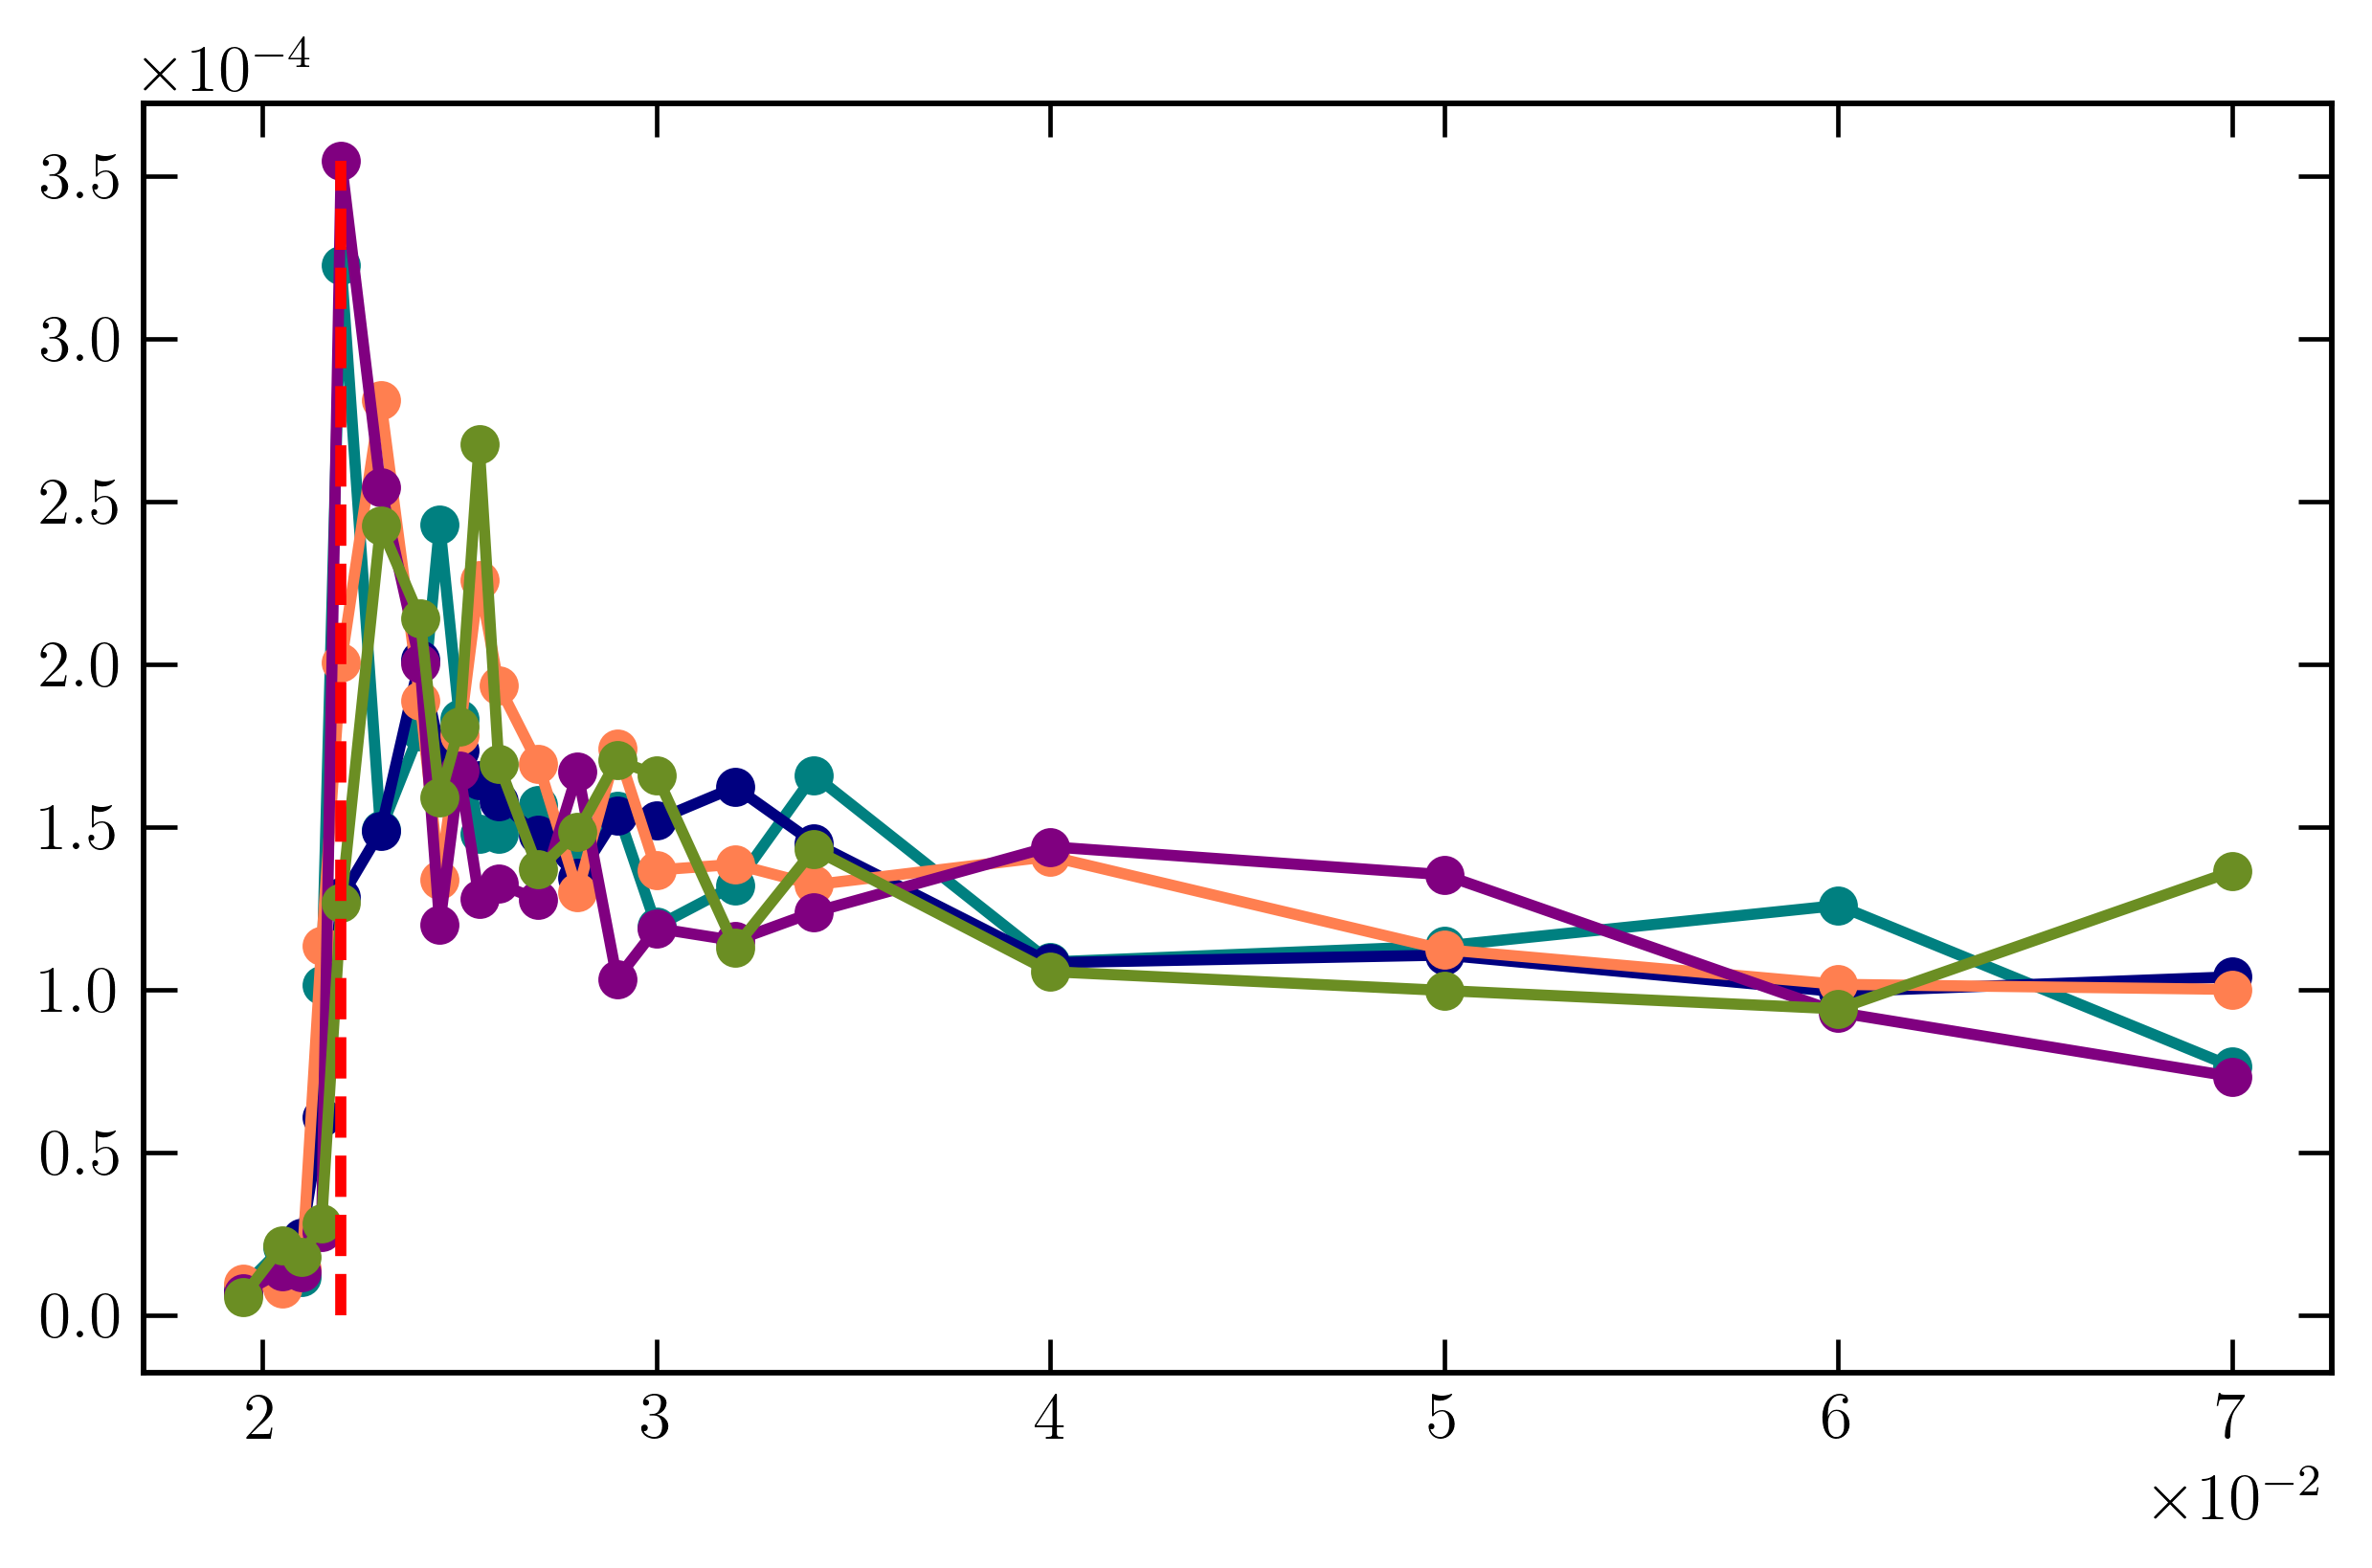

In [44]:
cid_av_exp = np.nanvar(ac.cid[512][...,0], axis=(0,1))
# plot CID vs act for different exp
fig, ax = plt.subplots(figsize=(6,4))
for iexp in range(ac.Nexp[512]):
    ax.plot(ac.act[512], cid_av_exp[:,iexp], marker='o', label=f'Exp {iexp+1}')
ax.vlines(0.022, ymin=0, ymax=np.nanmax(cid_av_exp), colors='r', linestyles='dashed', label='Critical Activity')

In [ ]:
plot_abs=True
use_min=True
ac.plot_cid_and_deriv(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs, use_min=use_min);
ac.plot_div_and_deriv(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs, use_min=use_min);

In [12]:
ac.frac_tav[LX][:,0]

array([0.99862312, 0.99788158, 0.99613975, 0.9877594 , 0.97191832,
       0.95068208, 0.92014467, 0.90902948, 0.93639828, 0.94954961])

Figure saved to: data\nematic\figs\na\nb5cg4\divm_ddiv.pdf


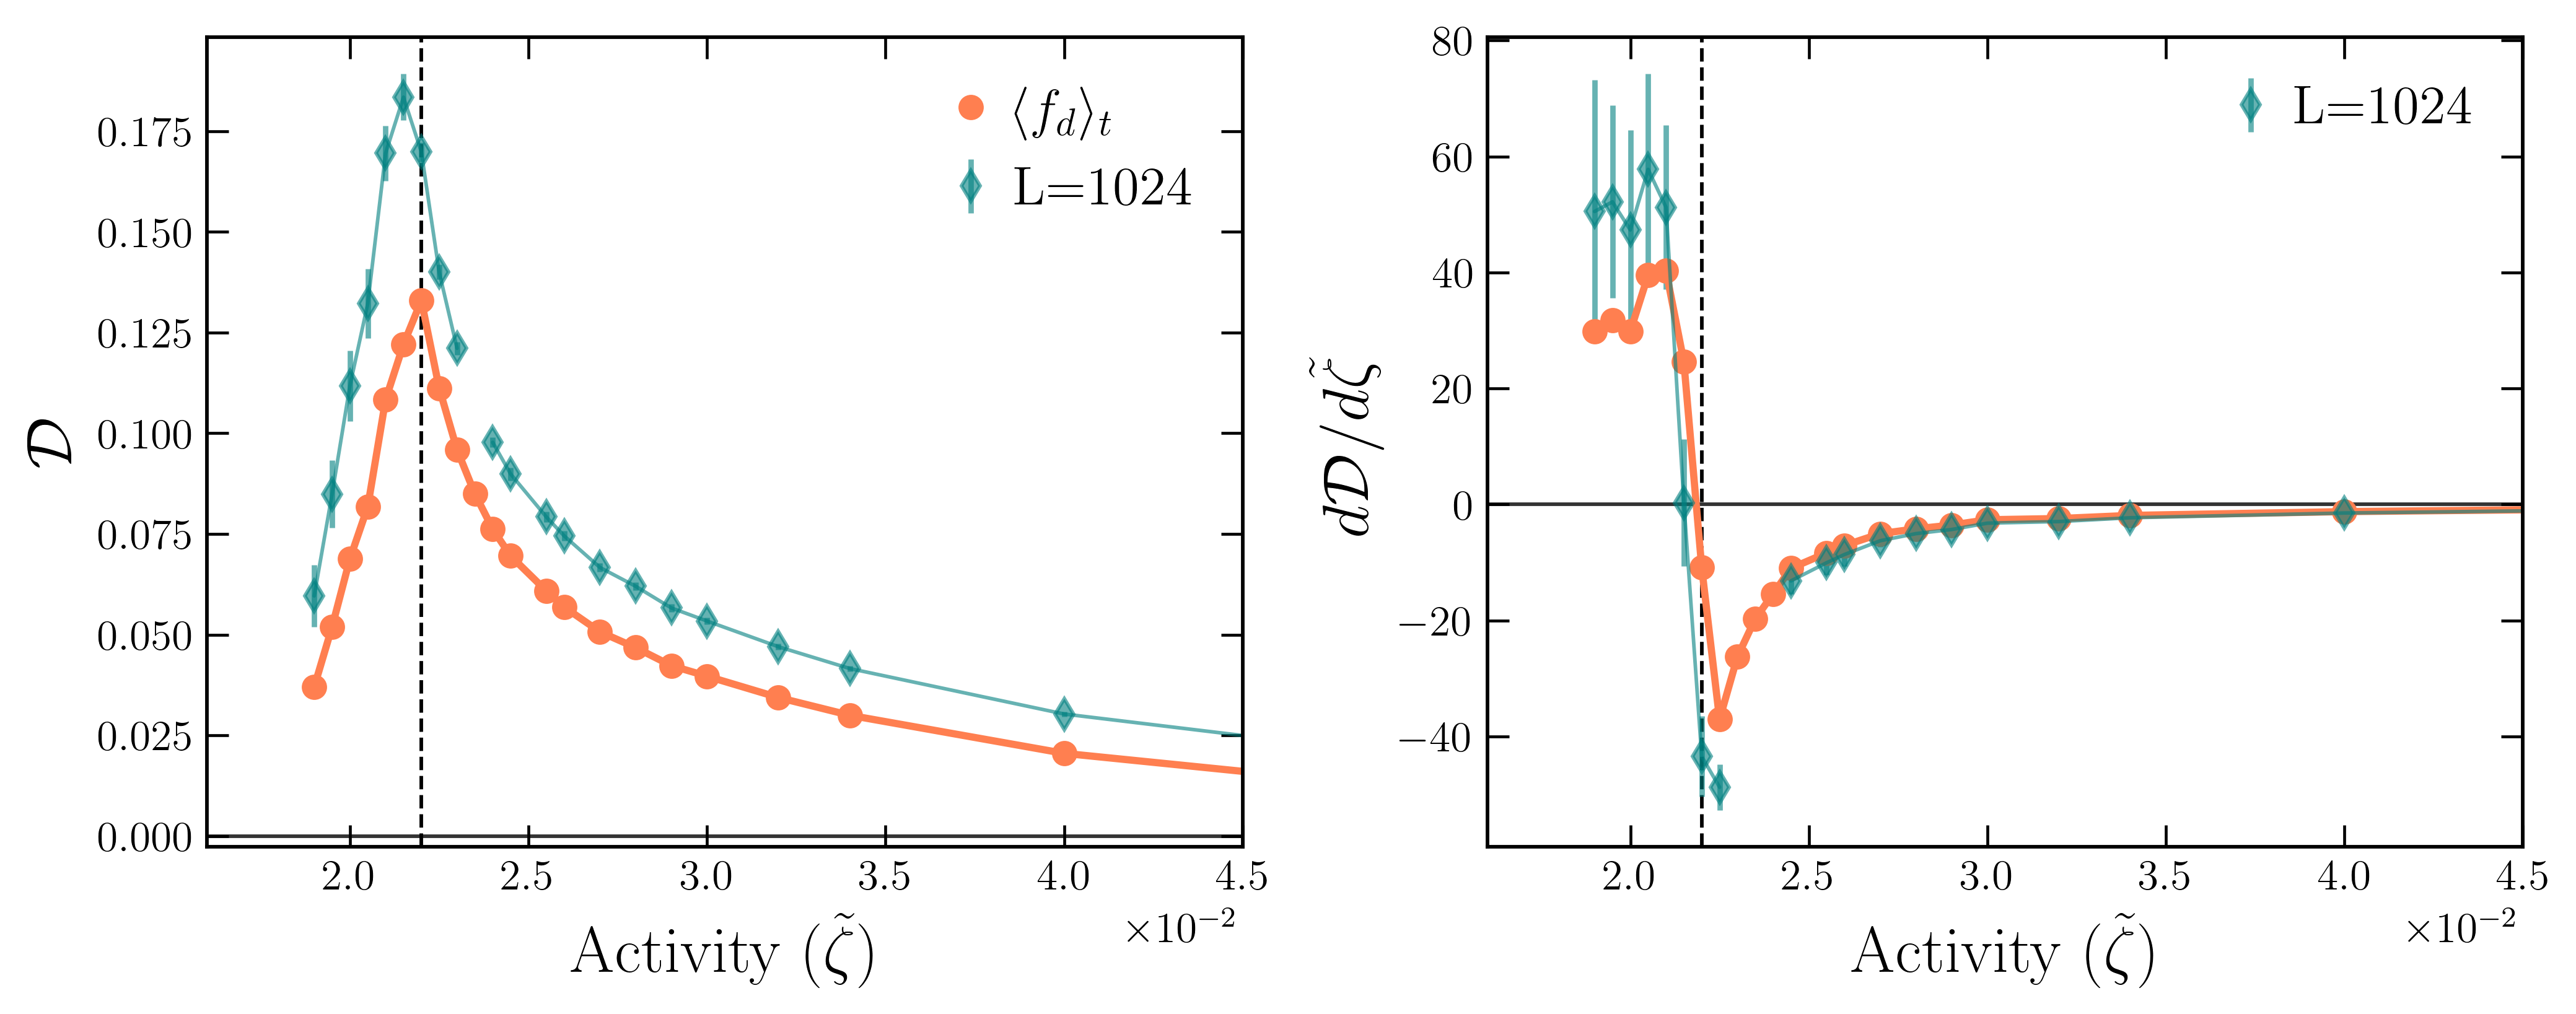

In [17]:
use_min=True
LX = 1024
fig, ax = ac.plot_div_and_deriv(L_list = [LX],save_path=ac.figs_save_path, 
                                act_critical=cid_dict['act_critical'], 
                                xlims=cid_dict['xlims'], 
                                plot_abs=False, use_min=use_min);
# plot frac_tav on top
ax[0].plot(ac.act[LX], 1-ac.frac_tav[LX][:,0], 'o-', label=r'$\langle f_d \rangle_t$', color='C2')
ax[1].plot(ac.act[LX], -1*ac.dfrac[LX][:,0], 'o-', label=r'$d\langle f_d \rangle_t / dA$', color='C2')
ax[0].legend()

In [ ]:
ac.plot_div_fluc(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], use_min=use_min, xlims=cid_dict['xlims'], plot_abs=plot_abs);

In [ ]:
plot_abs = False
ac.plot_div_fluc(L_list = [LX],save_path=ac.figs_save_path, use_min=False, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);
ac.plot_div_fluc(L_list = [LX],save_path=ac.figs_save_path, use_min=use_min, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);

In [ ]:
ac.plot_cid_fluc(L_list = [LX],save_path=ac.figs_save_path, use_min=use_min, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);

In [ ]:
ac.plot_cid_moments(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'],);
ac.plot_div_moments(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'],);

In [ ]:
#### Plot cid/div and derivatives
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_and_deriv(save_path=figs_save_path, xlims=xlims, plot_abs=True,);
fig1, ax1 = ac.plot_div_and_deriv(save_path=figs_save_path, xlims=xlims, plot_abs=True,);


In [ ]:
#### Plot cid/div fluc and derivatives
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_fluc(save_path=figs_save_path,xlims=xlims, plot_abs=True,);
fig1, ax1 = ac.plot_div_fluc(save_path=figs_save_path, xlims=xlims, plot_abs=True, plot_div_per=True);

In [ ]:
## Plot cid/div moments
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_moments(L_list=ac.L_list, save_path=figs_save_path, xlims=xlims,);
fig1, ax1 = ac.plot_div_moments(L_list=ac.L_list, save_path=figs_save_path, xlims=xlims,);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


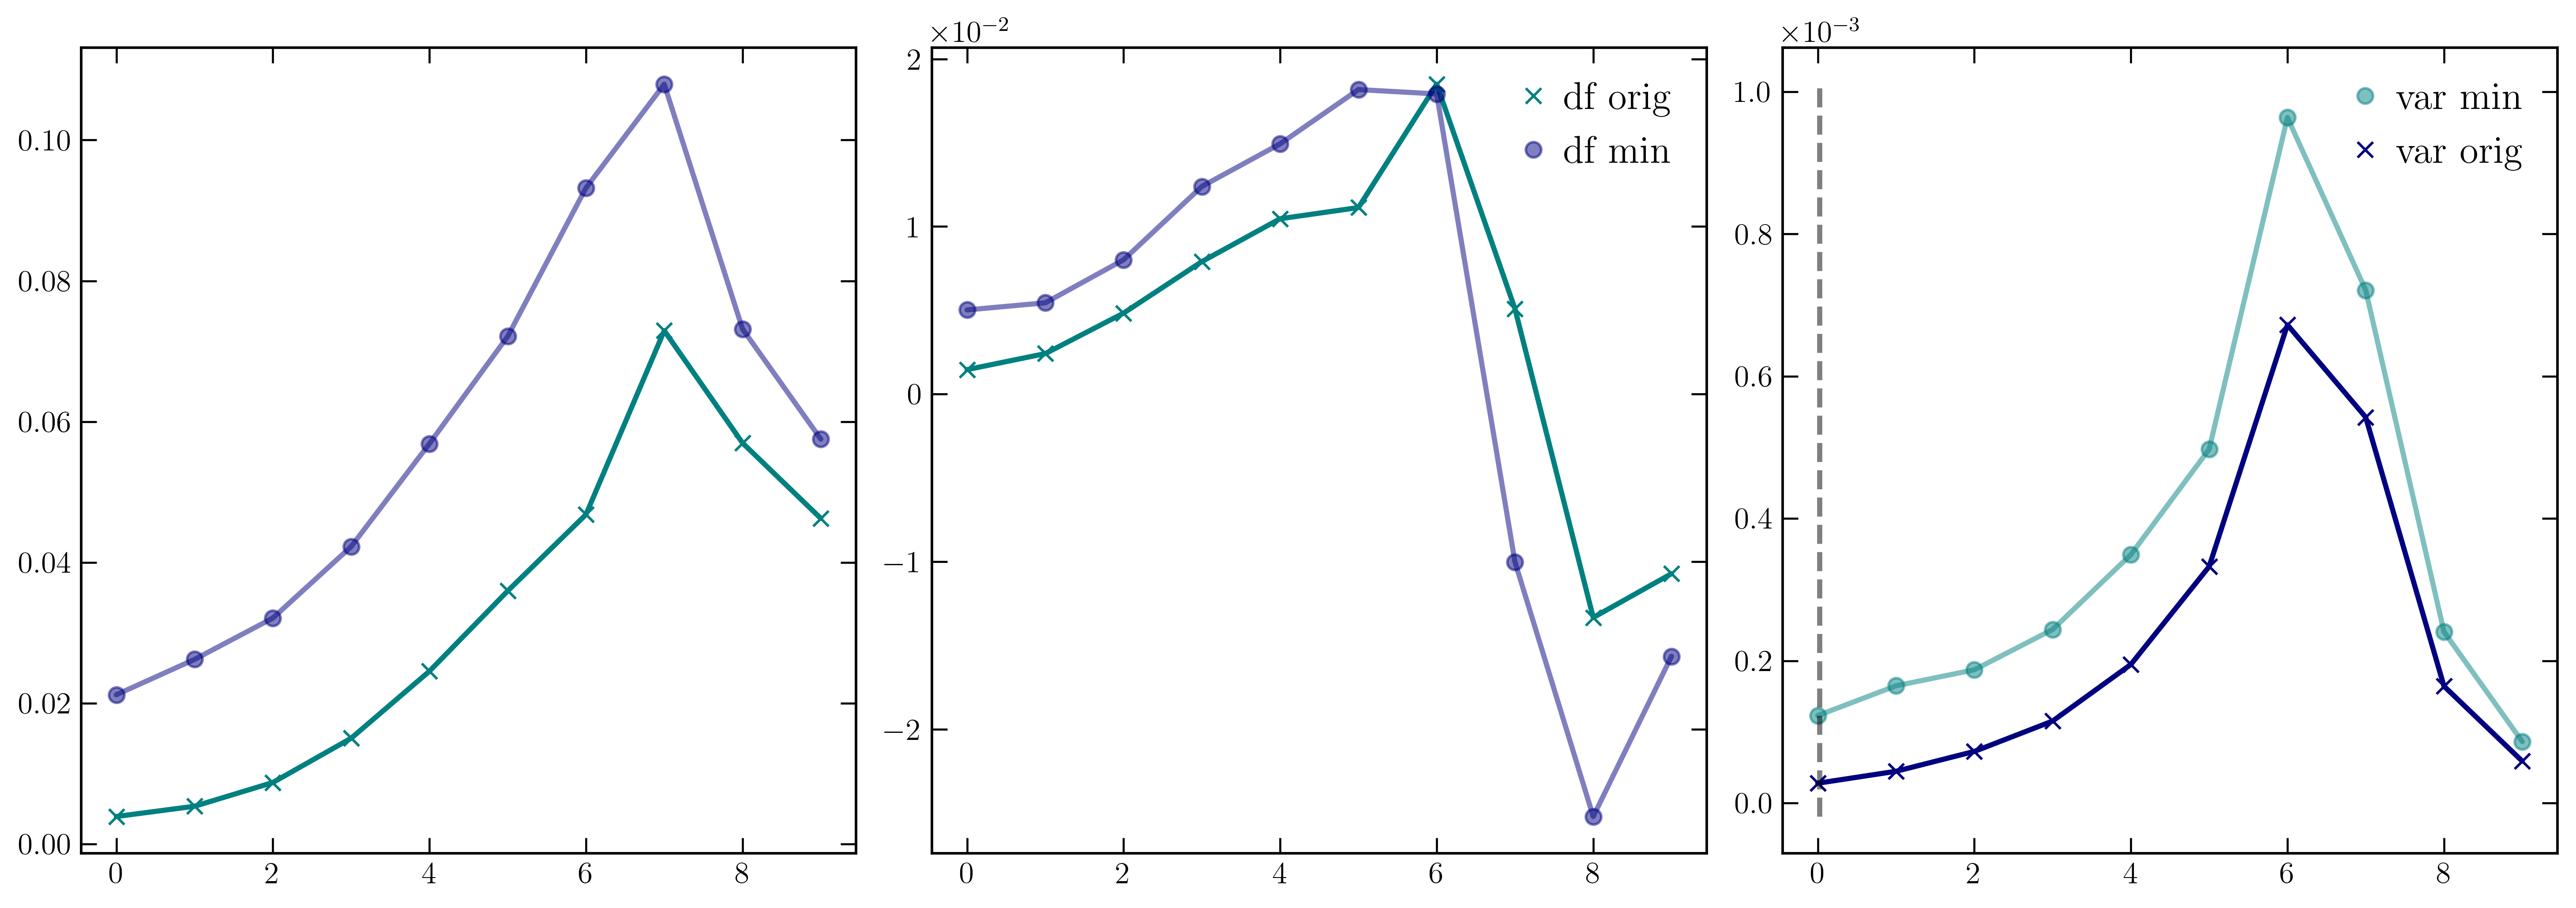

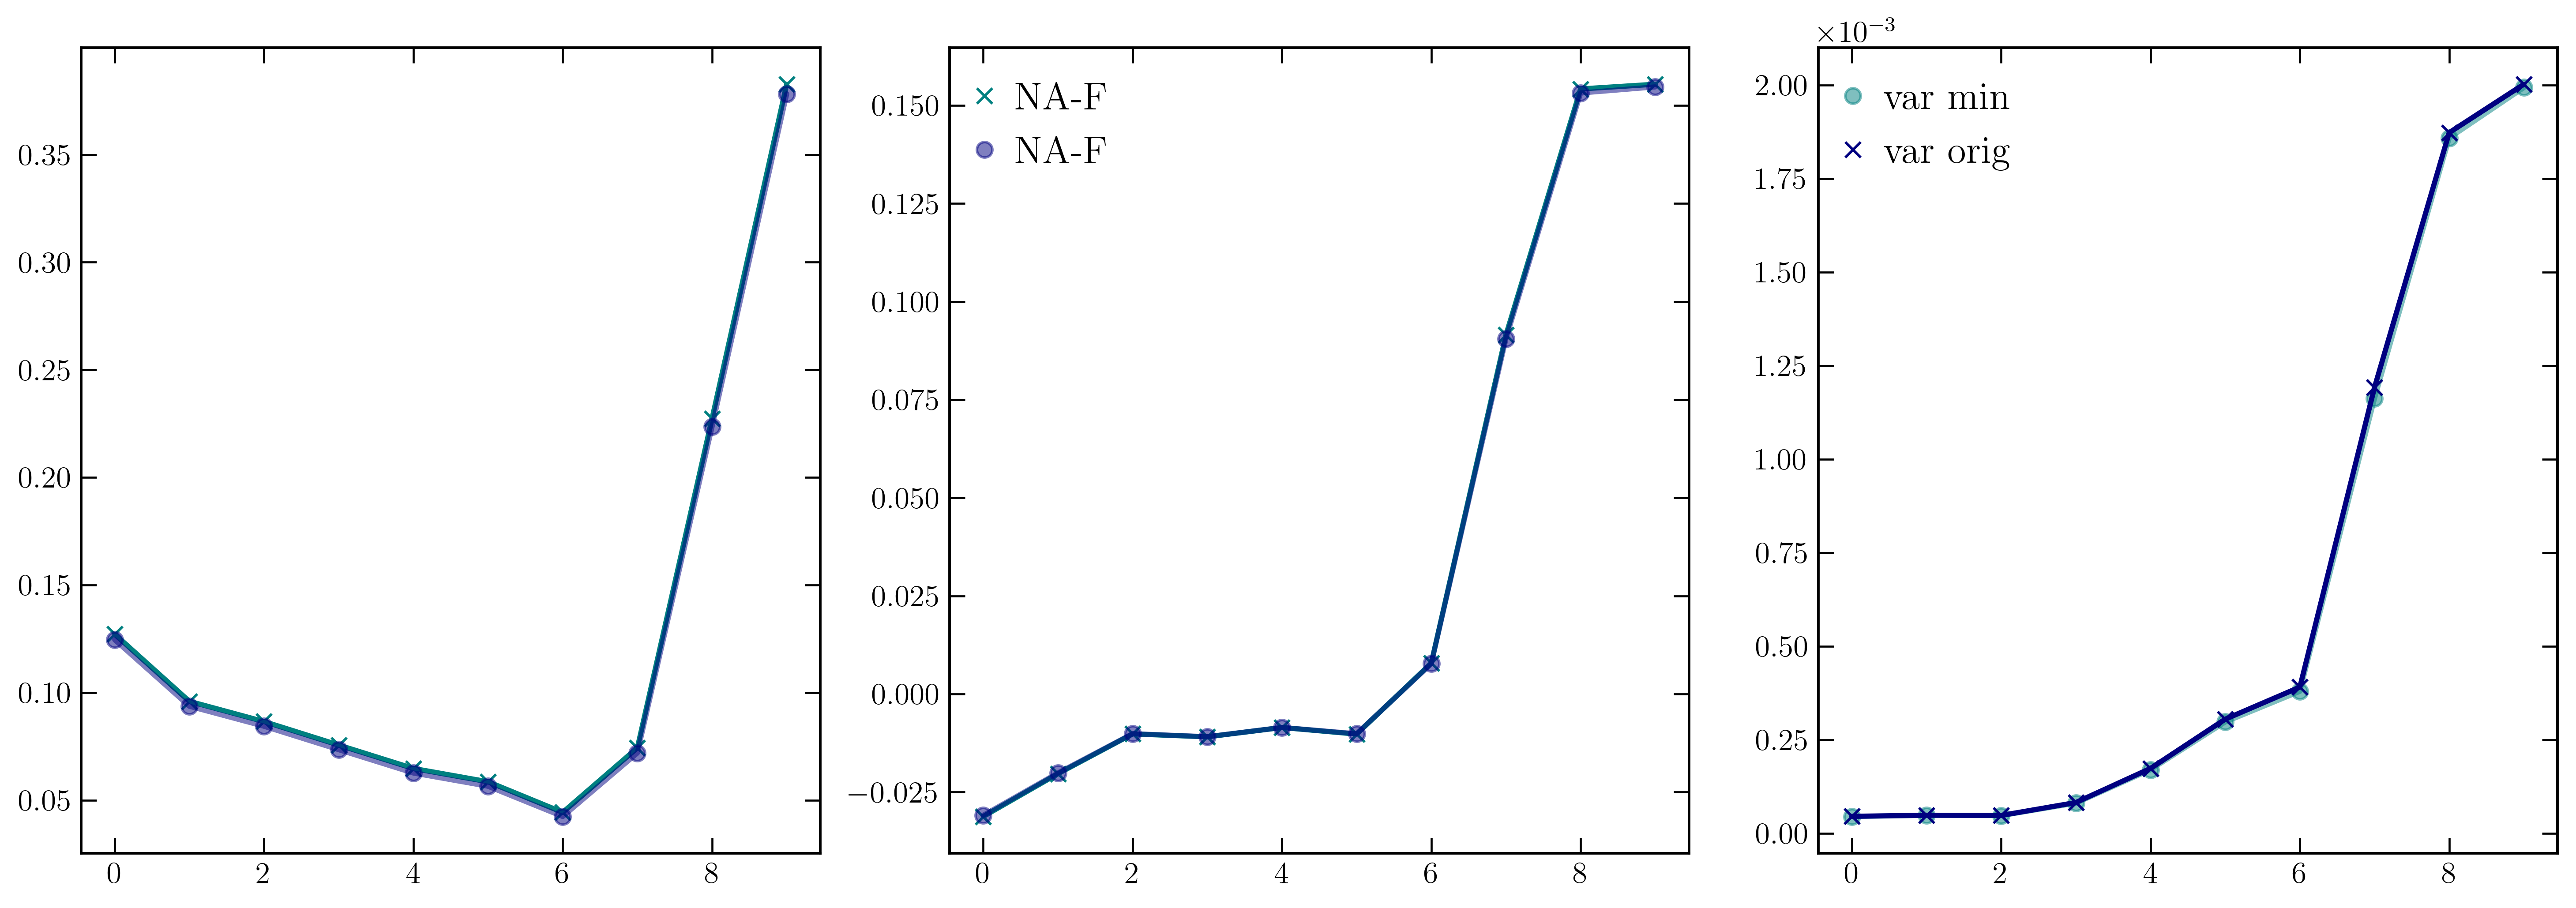

In [ ]:
npz_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\Universality\\data\\nematic\\na1024ndg\\cid_data_nb{nbits}cg{cg}.npz'
data = np.load(npz_path, allow_pickle=True)
data.files
cidf = data['cid_minmax']
fracf = data['frac_minmax']

LX=1024
#npz_path = r'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\Universality\\data\\nematic\\na1024f\\cid_data_nb5cg4.npz'
#data = np.load(npz_path, allow_pickle=True)
act_list = ac.act[LX]
#cidf = data['cid_minmax']
#fracf = data['frac_minmax']
cidf_tav, varf, varpf = calc_time_avs_ind_samples(cidf[...,0], ac.conv[ac.L_list[0]], Nexp=1,unc_multiplier=20,ddof=1)
fracf_tav, varff, varfpf = calc_time_avs_ind_samples(fracf[...,0], ac.conv[ac.L_list[0]], Nexp=1,unc_multiplier=20,ddof=1)
dcidf = calc_central_derivative(act_list, cidf_tav[:,0], cidf_tav[:,1])
dfracf = calc_central_derivative(act_list, fracf_tav[:,0], fracf_tav[:,1])

fig, ax = plt.subplots(ncols=3, figsize=(14,5))
ax[0].plot(act_list, 1-ac.frac_tav[LX][:,0], '-x')
ax[0].plot(act_list, 1-fracf_tav[:,0], '-o', alpha=0.5)
#ax[0].set_xlim(0.016, 0.045)
ax[1].plot(act_list, -1*ac.dfrac[LX][:,0], '-x', label='df orig')
ax[1].plot(act_list, -1*dfracf[:,0], '-o', alpha=0.5, label='df min')
#ax[2].plot(act_list, varfpf[:,0]/(1-fracf_tav[:,0]), '-o', alpha=0.5, label='var min')
#ax[2].plot(act_list, ac.frac_var[LX][:,0]/(1-ac.frac_tav[LX][:,0]), '-x', label='var orig')
ax[2].plot(act_list, varff[:]/(1), '-o', alpha=0.5, label='var min')
ax[2].plot(act_list, ac.frac_var[LX][:]/(1), '-x', label='var orig')
#ax[2].set_xlim(0.016, 0.045)    
ylim = ax[2].get_ylim()
ax[2].vlines(0.022, ylim[0],ylim[1],color='k', linestyle='--', alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
#ax[1].set_xlim(0.016, 0.045)

fig2, ax2 = plt.subplots(ncols=3, figsize=(14,5))
ax2[0].plot(act_list, ac.cid_tav[LX][:,0], '-x')
ax2[0].plot(act_list, cidf_tav[:,0], '-o', alpha=0.5)
#ax2[0].set_xlim(0.016, 0.045)
ax2[1].plot(act_list, ac.dcid[LX][:,0], '-x', label='NA-F')
ax2[1].plot(act_list, dcidf[:,0], '-o', alpha=0.5, label='NA-F')
#ax2[1].set_xlim(0.016, 0.045)
ax2[2].plot(act_list, varf[:], '-o', alpha=0.5, label='var min')
ax2[2].plot(act_list, ac.cid_var[LX][:], '-x', label='var orig')
#ax2[2].set_xlim(0.016, 0.045)

ax2[0].legend()
ax2[1].legend()
ax2[2].legend()

In [ ]:
cidf